In [1]:
import numpy as N
import numpy.random as NR
import pandas
import tqdm
import seaborn

seaborn.set_style('whitegrid')

import tqdm
import torch as T
import torch.distributions as TD
import torch.distributions.constraints as TDC
import torch.nn as TN
import torch.nn.functional as TNF
import pyro as P
import pyro.infer as PI
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS
import pyro.optim as PO
import pyro.distributions as PD
import pyro.nn as PN
import matplotlib.pyplot as plt
P.set_rng_seed(0)

In [2]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('small')
import igg
import model
import guide_nn_small as guide
import guide_lstm_cell_small as guide_lstm_cell
M = 20

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n0 = count_parameters(guide._nn_model_sub_l__i)
n1 = count_parameters(guide._nn__site0)
n2 = count_parameters(guide._nn_model_y)
n3 = count_parameters(guide._nn_model_x)
n4 = count_parameters(guide._nn_aggregate_result)
print("guide_nn_small:", n0, n1, n2, n3, n4, "total:", n0+n1+n2+n3+n4)
n0 = count_parameters(guide_lstm_cell.lstm)
n1 = count_parameters(guide_lstm_cell._nn_model_x)
n2 = count_parameters(guide_lstm_cell._nn_model_y)
n3 = count_parameters(guide_lstm_cell._nn_model_sub_l__i)
print("guide_lstm_cell_small:", n0, n1, n2, n3, "total:", n0+n1+n2+n3)

guide_nn_small: 90 152 34 42 104 total: 422
guide_lstm_cell_small: 384 18 18 18 total: 438


In [4]:
def draw(ind=True):
    if ind:
        return {"obs": 16.}  
    mu_1 = NR.uniform(-10, 10)
    mu_2 = NR.uniform(-10, 10)
    x_1 = NR.normal(mu_1, 3.0)
    y_1 = NR.normal(mu_2, 3.0)
    obs = NR.normal(x_1 * x_1 + y_1 * y_1, 0.5, (1,))
    return {"obs" : float(obs.astype('float32'))}
draw()

{'obs': 16.0}

In [5]:
def make_plot(x, y, main, savepath=None):
    plt.scatter(x, y, alpha=0.05)
    plt.title(main)
    plt.xlabel("x")
    plt.ylabel("y")
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

In [6]:

# nuts_kernel = NUTS(model.model)
# mcmc = MCMC(nuts_kernel, num_samples=1000)
# mcmc.run(M, {"obs":16.})
# model_samples = mcmc.get_samples()
# model_a = model_samples["x"].detach().numpy()
# model_b = model_samples["y"].detach().numpy()
# make_plot(model_a, model_b, main="model, obs="+str(16))

In [7]:
smoke_test = False

In [8]:
n_steps = 20000 if not smoke_test else 100
interval = 50 
num_inference_samples = 2000 if not smoke_test else 5
num_samples = 2000
obs_list = [draw(False) for _ in range(n_steps)]
steps = []
loss_lstm = []
loss_lstm_cell = []
loss_rnn = []
loss_nn = []

In [9]:
# importance = P.infer.Importance(model.model, num_samples=num_inference_samples)
# is_posterior = importance.run(M=M, observations={"obs": 16.})
# is_marginal = P.infer.EmpiricalMarginal(is_posterior, ["x", "y"])
# is_samples_x = []
# is_samples_y = []
# for _ in range(5000):
#     sample = is_marginal()
#     x = float(sample[0])
#     y = float(sample[1])
#     is_samples_x.append(x)
#     is_samples_y.append(y)
# make_plot(is_samples_x, is_samples_y, main=f"IS, obs={16}, ess={T.round(importance.get_ESS())}")

In [10]:
def sample_posterior(csis, num_samples=num_samples, obs=16.):
    if smoke_test:
        num_samples = 100
    posterior = csis.run(M=M, observations={"obs": obs})
    marginal = P.infer.EmpiricalMarginal(posterior, ["x", "y"])
    csis_samples_x = []
    csis_samples_y = []
    for _ in range(num_samples):
        sample = marginal()
        x = float(sample[0])
        y = float(sample[1])
        csis_samples_x.append(x)
        csis_samples_y.append(y)
    return csis_samples_x, csis_samples_y
def sample_x_y_guide(guide_fn, num_samples=num_samples, obs=16.):
    if smoke_test:
        num_samples = 100
    guide_x = []
    guide_y = []
    for _ in range(num_samples):
        x, y =guide_fn(M, {"obs" : obs})
        guide_x.append(float(x))
        guide_y.append(float(y))
    return guide_x, guide_y   
    

In [11]:
P.clear_param_store()
optimiser = PO.Adam({"lr": 0.001})
csis = PI.CSIS(model.model, guide_lstm_cell.model, optimiser, num_inference_samples=num_inference_samples)

avg_l = 0
for step in tqdm.trange(n_steps):
    obs = obs_list[step]
    loss = csis.step(M, observations=obs)
    avg_l += loss
    if (step + 1) % interval == 0:
        loss_lstm_cell.append(N.log(avg_l))
        avg_l = 0

guide_x, guide_y = sample_posterior(csis)
ess = csis.get_ESS()
make_plot(guide_x, guide_y, main=f"LSTM_W/_IS, M={M}, ESS={T.round(ess)}", savepath=f"figures/lstm_is_{M}.png")
guide_fn_x, guide_fn_y = sample_x_y_guide(guide_lstm_cell.model)
make_plot(guide_fn_x, guide_fn_y, main=f"LSTM_W/O_IS, M={M}, ESS={T.round(ess)}", savepath=f"figures/lstm_nn_{M}.png")
print(ess)
print(guide_x, guide_y)
print(guide_fn_x, guide_fn_y)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:04:54<00:00,  5.14it/s]


tensor(15.8844)
[13.318002700805664, 15.777400970458984, 15.777400970458984, 12.872871398925781, 4.6311354637146, 10.88779067993164, 3.596688747406006, 13.318002700805664, 6.958831310272217, -3.5021486282348633, 5.5103607177734375, 6.958831310272217, -0.20647716522216797, 8.440563201904297, 13.89330768585205, -0.20647716522216797, 6.542948246002197, 13.89330768585205, -3.5021486282348633, -3.5021486282348633, 4.6311354637146, 8.440563201904297, 12.872871398925781, -3.5021486282348633, -0.20647716522216797, 4.6311354637146, 4.6311354637146, 13.89330768585205, -0.20647716522216797, 9.583329200744629, 8.440563201904297, 6.542948246002197, 6.542948246002197, 15.777400970458984, -3.5021486282348633, 3.596688747406006, 9.583329200744629, 4.6311354637146, 11.971691131591797, -3.5021486282348633, 11.971691131591797, 16.876705169677734, 7.759681701660156, 6.542948246002197, 10.88779067993164, -3.5021486282348633, 6.542948246002197, 13.89330768585205, 9.583329200744629, 4.6311354637146, 10.88779

In [12]:
P.clear_param_store()
optimiser = PO.Adam({"lr": 0.001})
csis = PI.CSIS(model.model, guide.model, optimiser, num_inference_samples=num_inference_samples)

avg_l = 0
for step in tqdm.trange(n_steps):
    obs = obs_list[step]
    loss = csis.step(M, observations=obs)
    avg_l += loss
    if (step + 1) % interval == 0:
        steps.append(step)
        loss_nn.append(N.log(avg_l))
        avg_l = 0

guide_x, guide_y = sample_posterior(csis)
ess = csis.get_ESS()
make_plot(guide_x, guide_y, main=f"IGG_W/_IS, M={M}, ESS={T.round(ess)}", savepath=f"figures/igg_is_{M}.png")
guide_fn_x, guide_fn_y = sample_x_y_guide(guide.model)
make_plot(guide_fn_x, guide_fn_y, main=f"IGG_W/O_IS, M={M}, ESS={T.round(ess)}", savepath=f"figures/igg_nn_{M}.png")
print(ess)
print(guide_x, guide_y)
print(guide_fn_x, guide_fn_y)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:30:35<00:00,  3.68it/s]


tensor(494.1932)
[10.053983688354492, 15.324167251586914, 11.007466316223145, 5.408365249633789, 2.562145233154297, 10.373663902282715, 22.025285720825195, 0.46743112802505493, 15.534873008728027, 18.577781677246094, 16.972211837768555, 11.210267066955566, 6.758761882781982, 14.816892623901367, 6.068748950958252, 16.53672218322754, 0.9968979358673096, 5.983561038970947, 13.427835464477539, 5.8273444175720215, 10.667153358459473, 10.843449592590332, 22.025285720825195, 7.148678302764893, 13.637109756469727, 5.103733539581299, 7.148678302764893, -1.6126075983047485, 7.701132297515869, 6.701986789703369, 5.253686428070068, 14.147963523864746, 15.447962760925293, 13.4666109085083, 3.854355573654175, 4.141189098358154, 10.218132019042969, 9.464859962463379, 10.5126314163208, 5.500412464141846, 4.662298202514648, 25.017526626586914, 0.7037954926490784, 16.381914138793945, 10.548669815063477, 3.6553165912628174, 3.7371907234191895, 0.5172208547592163, 6.701986789703369, 5.292518615722656, 8.0

In [13]:
# P.clear_param_store()

# optimiser = PO.Adam({"lr": 0.001})
# csis = PI.CSIS(model.model, guide_rnn.model, optimiser, num_inference_samples=num_inference_samples)

# avg_l = 0
# for step in tqdm.trange(n_steps):
#     obs = obs_list[step]
#     loss = csis.step(M, observations=obs)
#     avg_l += loss
#     if (step + 1) % interval == 0:
#         loss_rnn.append(N.log(avg_l))
#         avg_l = 0
# guide_rnn_x, guide_rnn_y = sample_posterior(csis)
# ess = csis.get_ESS()
# make_plot(guide_rnn_x, guide_rnn_y, main=f"guide_rnn, obs={16}, ess={T.round(ess)}")
# guide_fn_x, guide_fn_y = sample_x_y_guide(guide_rnn.model)
# make_plot(guide_fn_x, guide_fn_y, main=f"guide_rnn direct from guide, obs={16}, ess={T.round(ess)}")

In [14]:
# P.clear_param_store()

# optimiser = PO.Adam({"lr": 0.001})
# csis = PI.CSIS(model.model, guide_lstm.model, optimiser, num_inference_samples=num_inference_samples)

# avg_l = 0
# for step in tqdm.trange(n_steps):
#     obs = obs_list[step]
#     loss = csis.step(M, observations=obs)
#     avg_l += loss
#     if (step + 1) % interval == 0:
#         steps.append(step)
#         loss_lstm.append(N.log(avg_l))
#         avg_l = 0
# guide_lstm_x, guide_lstm_y = sample_posterior(csis)
# ess = csis.get_ESS()
# make_plot(guide_lstm_x, guide_lstm_y, main=f"guide_lstm, obs={16}, ess={T.round(ess)}")
# guide_fn_x, guide_fn_y = sample_x_y_guide(guide_lstm.model)
# make_plot(guide_fn_x, guide_fn_y, main=f"guide_lstm direct from guide, obs={16}, ess={T.round(ess)}")

observations to train is not a single point

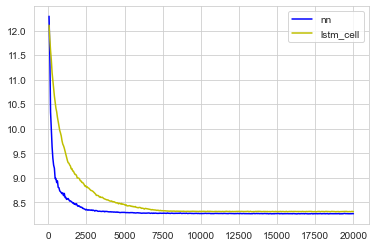

In [15]:
#plt.plot(steps, loss_lstm, "-r", label="lstm")
plt.plot(steps, loss_nn, "-b", label="nn")
plt.plot(steps, loss_lstm_cell, "-y", label="lstm_cell")
#plt.plot(steps, loss_rnn, "-g", label="rnn")
plt.legend()
plt.show()

In [16]:
# P.clear_param_store()

# optimiser = PO.Adam({"lr": 0.001})
# csis = PI.CSIS(model.model, guide_lstm.model, optimiser, num_inference_samples=num_inference_samples)

# avg_l = 0
# for step in tqdm.trange(n_steps):
#     obs = obs_list[step]
#     loss = csis.step(M, observations=obs)
#     avg_l += loss
#     if (step + 1) % interval == 0:
#         steps.append(step)
#         loss_lstm.append(N.log(avg_l))
#         avg_l = 0
# guide_lstm_x, guide_lstm_y = sample_posterior(csis)
# ess = csis.get_ESS()
# make_plot(guide_lstm_x, guide_lstm_y, main=f"guide_lstm, obs={16}, ess={T.round(ess)}")
# guide_fn_x, guide_fn_y = sample_x_y_guide(guide_lstm.model)
# make_plot(guide_fn_x, guide_fn_y, main=f"guide_lstm direct from guide, obs={16}, ess={T.round(ess)}")

In [17]:
# plt.plot(steps, loss_lstm, "-r", label="lstm")
# plt.plot(steps, loss_nn, "-b", label="nn")
# plt.legend()
# plt.show()



### 